In [1]:
import pandas as pd
import numpy as np
from numpy import nan
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

In [3]:
# A good way to read big data without worrying memory limitation
#TextFileReader = pd.read_csv("ProdLog202001.csv", chunksize = 1000000, usecols= ['PartitionKey', 'UserHostAddress', 'Path', 
#                                                                                "WhatText", "Postcode", "CategoryID"])  # the number of rows per chunk

#dfList = []
#for df in TextFileReader:
#    dfList.append(df)

#df = pd.concat(dfList,sort=False)
#df.to_csv('202001subset.csv', index=False)

In [2]:
df = pd.read_csv("202001subset.csv")
df.info() # row = 8073663
print(len(df["UserHostAddress"].unique())) # how many unique IP address, 200614 unique IP address from worldwide

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8073663 entries, 0 to 8073662
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   PartitionKey     int64  
 1   UserHostAddress  object 
 2   Path             object 
 3   WhatText         object 
 4   CategoryID       float64
 5   Postcode         float64
dtypes: float64(2), int64(1), object(3)
memory usage: 369.6+ MB
200614


In [9]:
print(df['Postcode'].isna().sum())

7968427


In [3]:
# drop UserHostAddress and Path duplicates so that each row now represents 1 demand.
df = df.drop_duplicates(subset=['UserHostAddress', 'Path'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)
df = df.drop_duplicates(subset=['UserHostAddress', 'CategoryID'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)
df = df.drop_duplicates(subset=['UserHostAddress', 'WhatText'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)

#df = df[df.WhatText != "-"] 
#df = df[df.WhatText != " "]
df["WhatText"] = df["WhatText"].replace("-", np.nan)
df["WhatText"] = df["WhatText"].replace(" ", np.nan)

200614
(3994249, 6)
200614
(568964, 6)
200614
(202730, 6)


In [4]:
# preprocessing for postcode
ip_info = pd.read_csv("ip_info_202001.csv", usecols= ['countryName', "zipCode", "isCrawler", "ipaddress"])
ip_info = ip_info.rename(columns = {'ipaddress': 'UserHostAddress'}, inplace = False)
df = pd.merge(df, ip_info, on='UserHostAddress', how='left')
df = df[df.UserHostAddress.notnull()]
print(df.shape)
df.head()

C:\Users\mib67\AppData\Local\Temp\ipykernel_9484\515865353.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  ip_info = pd.read_csv("ip_info_202001.csv", usecols= ['countryName', "zipCode", "isCrawler", "ipaddress"])


(202730, 9)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,zipCode,isCrawler
0,20200101,46.229.168.135,/ExploreMyCommunity,NaN,NaN,NaN,United States,20068,True
1,20200101,46.229.168.147,/Account,NaN,NaN,NaN,United States,20068,True
2,20200101,159.138.158.195,/Organisation/124352/Legacy_Laurel_Club_Southport,NaN,NaN,NaN,Hong Kong,NaN,False
3,20200101,66.249.65.133,/api/Search/Local,NaN,69.0,NaN,United States,94043,True
4,20200101,159.138.154.96,/New_South_Wales/Ku-Ring-Gai/Arts_Creatives,NaN,0.0,NaN,Hong Kong,NaN,False


In [5]:
# Filter out the non-Australia IP and crawler IP
# We only want QLD postcode here
df = df[df.countryName == "Australia"]
df = df[df.isCrawler == False]
print(df.shape)
df["Postcode"] = df['Postcode'].fillna(df["zipCode"])
df = df[df.Postcode.notnull()]
df["Postcode_4XXX"] = df["Postcode"].str.startswith("4")
df = df[df.Postcode_4XXX == True]
df.drop("Postcode_4XXX", inplace=True, axis=1)
df.drop("zipCode", inplace=True, axis=1)
print(df.shape) # 60257 rows after filter out the countryName and isCrawler of IP, also filter out missing value in Postcode
df.head()

(150975, 9)
(60257, 8)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,isCrawler
170,20200101,120.22.5.65,/api/a/pagestatus,NaN,NaN,4000,Australia,False
182,20200101,2001:8004:13c1:ba59:2917:4cd9:5ca3:a5f1,/Western_Australia/Canning/Health_Services/General_Health_Services/19775/159217/Unicare_Health_-_Bentley,NaN,80.0,4215,Australia,False
255,20200101,2001:8003:1c10:ca00:3500:f473:207f:e078,/api/Locations/id/15384,NaN,NaN,4215,Australia,False
334,20200101,106.71.190.191,/Queensland/Brisbane/Christmas_Fireworks/71929,NaN,NaN,4020,Australia,False
448,20200101,122.148.129.117,/Queensland/Moreton_Bay/Welfare_Assistance___Services/General_Welfare___Support_Services/16048/134593/Caboolture_Community_Action,NaN,119.0,4215,Australia,False


In [6]:
# preprocessing for WhatText
category = pd.read_csv("CIE_category.csv")
category = category[["ID", "Name"]]
category = category.rename(columns = {'ID': 'CategoryID'}, inplace = False)
category = category.rename(columns = {'Name': 'CategoryName'}, inplace = False)
category['CategoryID'] = category['CategoryID'].astype("float64")
category = category.drop_duplicates(keep='first') # There are fucking duplicates in categories, are you fucking serious!?
df = pd.merge(df, category, on='CategoryID', how='left')
print(df.shape)
df.head()

(60257, 9)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,isCrawler,CategoryName
0,20200101,120.22.5.65,/api/a/pagestatus,NaN,NaN,4000,Australia,False,NaN
1,20200101,2001:8004:13c1:ba59:2917:4cd9:5ca3:a5f1,/Western_Australia/Canning/Health_Services/General_Health_Services/19775/159217/Unicare_Health_-_Bentley,NaN,80.0,4215,Australia,False,General Health Services
2,20200101,2001:8003:1c10:ca00:3500:f473:207f:e078,/api/Locations/id/15384,NaN,NaN,4215,Australia,False,NaN
3,20200101,106.71.190.191,/Queensland/Brisbane/Christmas_Fireworks/71929,NaN,NaN,4020,Australia,False,NaN
4,20200101,122.148.129.117,/Queensland/Moreton_Bay/Welfare_Assistance___Services/General_Welfare___Support_Services/16048/134593/Caboolture_Community_Action,NaN,119.0,4215,Australia,False,General Welfare & Support Services


In [7]:
# get the category name for corresponding category ID, use category name to fill the missing value in WhatText
df["WhatText"] = df['WhatText'].fillna(df["CategoryName"])
df["Path_1"] = df["Path"].str.split("/").str[-1]
df["Path_2"] = df["Path"].str.split("/").str[-2]
df["WhatText"] = df['WhatText'].fillna(df["Path_1"])
df["WhatText"] = df['WhatText'].str.lower()
df["Path_2"] = df['Path_2'].str.lower()

df.to_csv('202001_preprocessed.csv', index=False)

In [38]:
df = pd.read_csv("202001_preprocessed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60257 entries, 0 to 60256
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PartitionKey     60257 non-null  int64  
 1   UserHostAddress  60257 non-null  object 
 2   Path             60257 non-null  object 
 3   WhatText         57440 non-null  object 
 4   CategoryID       39642 non-null  float64
 5   Postcode         60257 non-null  int64  
 6   countryName      60257 non-null  object 
 7   isCrawler        60257 non-null  bool   
 8   CategoryName     37303 non-null  object 
 9   Path_1           57372 non-null  object 
 10  Path_2           57614 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 4.7+ MB


In [39]:
# filter out values that related to system 
df = df[df.WhatText != "pagestatus"]
df = df[df.WhatText != "api-info"]
df = df[df.WhatText != "getresults"]
df = df[df.WhatText != "terms_and_conditions"]
df = df[df.WhatText != "register"]
df = df[df.WhatText != "local"]
df = df[df.WhatText != "search"]
df = df[df.WhatText != "nearme"]
df = df[df.WhatText != "opendata"]
df = df[df.WhatText != "tags"]
df = df[df.WhatText != "organisations"]
df = df[df.WhatText != "getservicebadges"]
df = df[df.WhatText != "services"]
df = df[df.WhatText != "log"]
df = df[df.WhatText != "id"]
df = df[df.WhatText != "councils"]
df = df[df.WhatText != "council"]
df = df[df.WhatText != "getcouncil"]
df = df[df.WhatText != " "]
df = df[df.WhatText != "getappid"]
df = df[df.WhatText != "click"]
df = df[df.WhatText != "savedevicetoken"]
df = df[df.WhatText != "login"]
df = df[df.WhatText != "file"]
df = df[df.WhatText != "verifyemail"]
df = df[df.WhatText != "redirect"]
df = df[df.WhatText != "unsubscribe"]
df = df[df.WhatText != "account"]
df = df[df.WhatText != "bylocalityid"]
df = df[df.WhatText != "categories"]
df = df[df.WhatText != "category"]
df = df[df.WhatText != "directory"]
df = df[df.WhatText != "results"]
df = df[df.WhatText != "save"]
df = df[df.WhatText != "updatestatus"]

In [40]:
# replace all numeric search queries with No_Information value
df['WhatText'] = df['WhatText'].mask(pd.to_numeric(df['WhatText'], errors='coerce').notna())
df["WhatText"] = df['WhatText'].fillna(df["Path_2"])

df['WhatText'] = df['WhatText'].mask(pd.to_numeric(df['WhatText'], errors='coerce').notna())
df["WhatText"] = df['WhatText'].fillna("No_Information")

#second time filtering
df = df[df.WhatText != "id"]
df = df[df.WhatText != "councils"]
df = df[df.WhatText != "council"]
df = df[df.WhatText != "getcouncil"]
df = df[df.WhatText != " "]
df = df[df.WhatText != "log"]
df = df[df.WhatText != "getappid"]
df = df[df.WhatText != "click"]
df = df[df.WhatText != "savedevicetoken"]
df = df[df.WhatText != "login"]
df = df[df.WhatText != "file"]
df = df[df.WhatText != "verifyemail"]
df = df[df.WhatText != "redirect"]
df = df[df.WhatText != "unsubscribe"]
df = df[df.WhatText != "account"]
df = df[df.WhatText != "bylocalityid"]
df = df[df.WhatText != "categories"]
df = df[df.WhatText != "category"]
df = df[df.WhatText != "directory"]
df = df[df.WhatText != "results"]
df = df[df.WhatText != "save"]
df = df[df.WhatText != "updatestatus"]
df = df[df.WhatText != "contactus"]
df = df[df.WhatText != "meetings_"]
df = df[df.WhatText != "holidaynotice"]
df = df[df.WhatText != "location"]
df = df[df.WhatText != "memberfeatures"]
df = df[df.WhatText != "getrecentupdates"]
df = df[df.WhatText != "eventwidget"]
df = df[df.WhatText != "exploremycommunity"]
df = df[df.WhatText != "advanced"]

df = df.reset_index(drop = True)
df.drop("Path", inplace=True, axis=1)
df.drop("isCrawler", inplace=True, axis=1)
df.drop("Path_1", inplace=True, axis=1)
df.drop("Path_2", inplace=True, axis=1)
df.drop("UserHostAddress", inplace=True, axis=1)
df.drop("CategoryID", inplace=True, axis=1)
df.drop("countryName", inplace=True, axis=1)

print(df.shape) # row = 55217
df.head()

(55213, 4)


,PartitionKey,WhatText,Postcode,CategoryName
0,20200101,general health services,4215,General Health Services
1,20200101,christmas_fireworks,4020,NaN
2,20200101,general welfare & support services,4215,General Welfare & Support Services
3,20200101,No_Information,4000,NaN
4,20200101,bunbury_acute_psychiatric_unit,4215,NaN


In [41]:
# find out the unique_values that's not in the category dictionary, this is so hard...
name = category["CategoryName"].unique()
name = pd.DataFrame (name, columns = ['CategoryName'])
name = name.rename(columns = {'CategoryName': 'unique_values'}, inplace = False)
name["unique_values"] = name['unique_values'].str.lower()
value_counts = df["WhatText"].value_counts().rename_axis('unique_values').reset_index(name='counts')
df_diff = pd.concat([value_counts, name]).drop_duplicates("unique_values", keep=False)

In [42]:
# Manually categorisation
df['CategoryName'] = np.where(df['WhatText'] == "No_Information", "No_Information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "events", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_clubs___interest_groups", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "welfare_assistance___services", "welfare assistance & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "volunteering", "general volunteering services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_centres__halls___facilities", "community halls", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aboriginal_services", "aboriginal support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "disability_services", "disability information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cairns_central_-_jp_service_centre", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sport", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "milne_bay_aquatic_and_fitness_centre", "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "youth_services", "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "find_a_jp_after_hours_website", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dodgers_touch_football_car_boot_sales", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "accommodation_services", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_palm_beach", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "crisis___emergency_services", "general crisis and emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_browns_plains", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_rockhampton", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_maryborough", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ageing_services", "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wildlife_rescue", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_ipswich", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aspley_rugby_league_football_club", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_north_child_safety_service_centre", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_housing_hub", "disability accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_biggera_waters", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_vincent_de_paul_-_food_vouchers", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cultural_and_migrant_services", "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "salvation_army_still_waters_-_women_s_crisis_accommodation", "crisis & emergency accommodation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "trail_run_australia___sunshine_coast", "outdoor recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_hervey_bay", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_deception_bay", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "southport_police_station", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_beenleigh", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "transport_services", "general transport services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "advocacy_services", "general advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "burleigh_car_boot_sales", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dv_connect", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "springfield_lakes_cheeky_monkeys_playgroup", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mudgeeraba_community_hall", "community halls", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_cleveland", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "busy_at_work_-_gympie_apprenticeship_services", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_strathpine", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "medicare_-_mackay", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_caboolture", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_nambour", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beros-_brisbane_emergency_response_outreach_service", "crisis counselling & intervention services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_helensvale_customer_service_branch", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_palm_beach_customer_service_branch", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "harmony_house-hervey_bay", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "busy_at_work_-_mareeba_employment_services", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "nq_cardiac_clinic", "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "redlynch_central_-_jp_service_centre", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_kingaroy", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wildlife_rescue_sunshine_coast_", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_green_shed_mitchell", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "liz_collett_s_gold_coast_line_dancers", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_maroochydore", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "just_aqua", "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "police_station-hervey_bay", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "helensvale_senior_citizens_club", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "yp_in_the_care_of_child_safety_", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "department_of_immigration_and_border_protection_-_brisbane", "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "public_dental_clinic_-_collingwood_park", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dental_clinic_-_bundaberg", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_bundall_customer_service_centre__formerly_surfers_paradise_", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sexual_health_clinic_-_townsville", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "redlands_community_oral_health_clinic", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "environment___conservation", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "help_employment___training", "general employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_nerang_administration_centre", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gladstone_community_mental_health_services", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_bundaberg", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "councilvolunteer", "general volunteering services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "diabetes_resource_centre_-_gold_coast_hospital", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_beaudesert", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "partners", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "police_station-maryborough", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "north_ward_health_campus__dental_clinic_townsville_", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "red_cross_homelessness_service_hub_-_aitkenvale", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "legal_assistance___information_services", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "manunda_-_jp_service_centre__raintrees_", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "inala_child_safety_service_centre", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "department_of_human_services_child_support_-_brisbane", "child youth & family health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_nerang", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_aboriginal__amp__islander_corp_alcohol__amp__drug_dependence_services", "aboriginal health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "health_services", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "adra_community_food_pantry", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "justice_of_the_peace_branch", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hedley_beare_centre_for_teaching___learning", "personal development activities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ndis_transport", "general transport services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_sound_society__roma_street_parkland", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "home_assist_secure_-_hervey_bay", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "police_station_gungahlin", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "romafire___first_aid", "ses, rural fire, lifesavers, search & rescue", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_adult_mental_health_service_-_maroochydore", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mobile_outreach_support_and_health_program_by_integrated_teams__moshpit_", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_andrews_private_hospital_-_after_hours_medical_service", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "carers_queensland_ndis_local_area_coordination_gympie", "carer information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beenleigh_neighbourhood_centre", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_robina", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "apple-touch-icon-precomposed.png", "No_Information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "busy_bees_mango_hill_playgroup", "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "australia_day_in_the_city_-_parade__concert__fireworks", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_housing_service_centre", "disability accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "townsville_hospital", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "caboolture_dental_clinic", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "apostolic_church_of_queensland_-_northern_district", "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dental_clinic_-_qeii_hospital", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beenleigh_community_oral_health_clinic", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "university_of_the_third_age_-_gold_coast", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mount_isa-gulf_child_safety_service_centre", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "fomo_adelaide_2020", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_smith_family_toowoomba", "special education programs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rockhampton_child_safety_service_centre", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_warwick", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tribfest_australia_2020___australia_day", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "springwood_community_centre", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "patient_transport_service", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_goodna", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_toowoomba", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "yellowbridge_qld_-_toowoomba_station_st", "disability accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dental_clinic_-_hervey_bay", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tai_chi-hervey_bay", "general cultural groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "child_services", "general child services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "maryborough_housing_service_centre", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "bunbury_acute_psychiatric_unit", "psychiatric services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_country_women_s_association_-_ipswich", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_forensic_mental_health_service", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "information___counselling", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "lifeline_shop_-_albany_creek", "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_woodridge", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "australian_red_cross_society_-_nerang_branch", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queen_elizabeth_ii_jubilee_hospital_-__qeii_", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gold_coast_hospital_carrara_health_centre", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "townsville_child_safety_service_centre", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "scouts_queensland_-_belmont", "children & youth clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cairns__cairns_central_shopping_centre", "general community facilities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "busy_at_work_-_bundaberg_apprenticeship_services", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_yeppoon", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "vaksbrisbane", "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "roma_hospital", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_country_women_s_association_-_coomera", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sarina_russo_job_access_-_nundah", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "springfield_united_football_club", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "robina_health_precinct_oral_health_services", "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "surfers_paradise_police_station", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sarina_russo_job_access_-_pialba", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rockhampton_base_hospital", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rotary_markets_gladstone", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "medicare_-_deception_bay", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "acute_inpatient_mental_health_unit_-_bundaberg", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "child_and_youth_mental_health_service__cymhs__-_mt_gravatt", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "salvation_army_-__qld_phone_service_", "crisis & emergency accommodation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "child_and_youth_mental_health_services__cymhs__-_rockhampton", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ipswich___district_lapidary_club_inc", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hope_centre_international_-_bowen_hills", "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_noosa", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wildlife_wanderers_care_group", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "centrelink_customer_service_centre_-_chermside", "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "westcourt_-_jp_service_centre__direct_factory_outlet_", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aqua_aerobics_classes_-_gold_coast_aquatic_centre", "aquatic sports", df['CategoryName'])#count = 10
df['CategoryName'] = np.where(df['WhatText'] == "communify_queensland_ltd", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ormeau_centre", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "channel_nine_gold_coast_news", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hart4000_-_homelessness_assistance_and_referral_team", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "dr_farhan_syed_t_a_syed_cardiology_pty_ltd_as_trustee_for_syed_cardiology_trust", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "goodlife_community_baptist_church_-_buderim", "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "oxley_disability_services", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "department_of_social_services_-_queensland", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_karp_court__bundall", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "women_s_shelter_-_rockhampton", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "bulimba_community_centre", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "caravonica_waters", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "lake_mac_festival", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_bird_breeders_club", "animal clubs & hobbies", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "able_australia_services_-_jimboomba", "disability respite and activity centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "food vans and kitchens (welfare assistance & services)", "welfare assistance & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "animal_services", "animal shelters", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tara_memorial_swimming_pool_-_swim_fit", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "public_trustee_-_toowoomba", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "urangan_bowls_club_inc", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "act_for_kids_-_townsville", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "crows_nest_village_markets", "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sunshine_coast_scavenger_hunt__caloundra_on_the_coast", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "urangan_bowls_club_inc", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aged_care_assessment_team__acat__-_mackay", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "my_first_aid_course", "ses, rural fire, lifesavers, search & rescue", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tiny_tots_caboolture_playgroup", "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "everglow_community_care_links_-_ayr", "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "girl_guides_-_camp_hill", "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "playful_possums_playgroup", "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "parents_without_partners_-_gold_coast", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "central_highlands_family_day_care_scheme", "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tropfest_australia", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "max_employment_-_russell_island", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gold_coast_veteran_golfers_association_-_robina", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aftercare_-_youth_residential_rehabilitation_unit__greenslopes", "health rehabilitation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "maroochydore_queensland_government_service_centre", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "browns_plains_early_years_centre", "youth information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "renal_unit", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "weight_watchers_-_ipswich", "general self help services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "act_policing__belconnen_", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_knit_and_natter", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "emerald_housing_service_centre", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "probus_club_of_hope_island__combined_", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mulungu_mareeba_child_and_family_centre", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_health_centre_-_nambour", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "connected_families_program", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "alcohol__tobacco_and_other_drugs_service__atods__-_bundaberg", "drug & alcohol services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "clinic_87_hiv_sexual_health_service", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "specialist homelessness services (accommodation services)", "specialist homelessness services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gladstone_housing_service_centre", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_cecil_plains_crier_association", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sera_s_women_s_shelter_-_townsville_city", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "jaguar_drivers_club_of_queensland__gold_coast_register_", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "breastscreen_queensland_nambour_service", "health screening services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_building_and_construction_commission__qbcc_", "industry bodies", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "senior_citizens_-_townsville", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "holland_park_ward_office_-_councillor_krista_adams", "local advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "nights_of_daredevils_-_monster_trucks", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_embroiderers__guild_queensland_inc__toowoomba_branch__inc_", "crafts", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_vincent_de_paul_society_-_families_back_on_track__fbot_", "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "volunteerreminder", "general volunteering services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rockhampton_district_aged_care_assessment_team__acat_", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "woodturners_society_of_queensland_inc_-_greenslopes", "crafts", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mahjong", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "companion_card_-_queensland", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "girl_guides_-_kenmore", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "commonwealth_respite_and_carelink_centre_-_south_brisbane", "disability information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ear__nose___throat_surgery", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hervey_bay_model_railway_interest_group", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "springfield_junior_rugby_league_football_club", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "park_avenue_state_school_-_special_education_program", "special education programs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tuggeranong_walk-in_centre", "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cherbourg_murgon_youth_justice_centre", "aboriginal health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "peachey_community_garden", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "alexandra_donoghue_clinical_consulting", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "horse_riding_school_hope_island__gold_coast_equestrian_centre_", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "m-yes_youth_mentoring_brisbane_and_logan_", "children & youth clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "op_shop", "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "home_assist_secure_-_bribie_island", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_synod_office", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "get_active_expo_2020", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "c_k_-_railway_community_preschooling_centre", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "australian_national_chinese_women_s_federation", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_health_centre_-_rockhampton", "community health & medical", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "central_referral_hub_-_primary_care_partnership_unit", "health rehabilitation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ormeau_royals_netball_", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "crows_nest_swimming_pool", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_children_and_family_centre", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "runaway_bay_netball_club", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ormeau_royals_netball_", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "needle_syringe_program", "drug & alcohol services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "evolve_therapeutic_service", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "injinoo_primary_health_care_centre", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mercy_family_services_-_townsville_family_and_child_connect", "child youth & family health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "city_of_gold_coast_-_coolangatta_customer_service_branch", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_tuberculosis_control__centre", "specialists", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "128_army_cadet_unit_-_morton_depot__yandina", "children & youth clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "food_parcels", "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mens_shed_-_carina", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "nwrh___kukatja_place", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_junior_rugby_league", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wide_bay_sexual_health_service-bundaberg", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "with_one_voice_gold_coast_choir", "indoor recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "yirs_one_stop_youth_shop_inc_", "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "millmerran_service_centre", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "optimise_health_and_wellness_pty_ltd", "allied health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "neighbourhood_watch_-_helensvale_", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "middlemount_medical_centre", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "career_keys_-_marsden", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "men___work-maryborough", "general employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "general crisis and emergency services (crisis & emergency services)", "general crisis and emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "north_and_west_remote_health_-_north_west__mount_isa_", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "seniors clubs & social groups (ageing services)", "seniors clubs & social groups", df['CategoryName']) #count = 5 end

In [43]:
df['CategoryName'] = np.where(df['WhatText'].str.contains("jp"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("justice_of_the_peace"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("court"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hospital"), "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("police"), "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("mental_health"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("centrelink"), "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("dental"), "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("oral"), "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("legal"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("wildlife"), "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("busy_at_work"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("medicare"), "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("aquatic"), "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("aqua"), "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("child_safety"), "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("migrant"), "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("car_boot_sales"), "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("immigration"), "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("church"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("psychiatric"), "psychiatric services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("women_s_association"), "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("red_cross"), "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("scout"), "children & youth clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("job_access"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("football_club"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("salvation_army"), "crisis & emergency accommodation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hope_centre"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("homeless"), "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("cardiology"), "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("baptist"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("community_centre"), "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("richmond_fellowship"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rfq"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("trustee"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("act_for_kids"), "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("council"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("university_of_the_third_age"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("u3a"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("first_aid"), "ses, rural fire, lifesavers, search & rescue", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("playgroup"), "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("employment"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rehabilitation"), "health rehabilitation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("ymca"), "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("housing_service"), "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("construction"), "industry bodies", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("screen"), "health screening services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("market"), "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("doctor"), "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("carer"), "carer information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("libraries"), "general community facilities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hall"), "community halls", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("home_assist"), "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("girl_guides"), "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("youth_justice"), "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("state_school"), "state (primary and high schools)", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("senior_citizen"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("able"), "disability respite and activity centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("centacare"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("alcohol"), "drug & alcohol services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("lifeline"), "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rugby"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("football"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("veteran"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rotary"), "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("corrective"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("yellowbridge"), "disability accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("blue_care"), "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("roseberry"), "youth accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("probation_and_parole"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("ndis"), "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("library"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("libraries"), "general communication & information", df['CategoryName'])

In [44]:
print(df['CategoryName'].isna().sum())

4425


In [77]:
name.sort_values("unique_values")

,unique_values
61,aboriginal health services
80,aboriginal support services & counselling
33,abuse & assault services
48,adult education
65,adult health services
0,aged care accommodation services
9,ageing accommodation
66,ageing health services
10,ageing information & counselling
11,ageing respite & activity centres


In [78]:
df_diff

,unique_values,counts
0,No_Information,3830.0
15,events,934.0
20,community_clubs___interest_groups,667.0
29,welfare_assistance___services,473.0
47,volunteering,244.0
69,community_centres__halls___facilities,160.0
71,aboriginal_services,152.0
72,disability_services,149.0
73,cairns_central_-_jp_service_centre,148.0
75,mackay,142.0


In [22]:
df_diff.head(20)

,unique_values,counts
0,No_Information,3830.0
15,events,934.0
20,community_clubs___interest_groups,667.0
27,welfare_assistance___services,473.0
47,volunteering,244.0
69,community_centres__halls___facilities,160.0
71,aboriginal_services,152.0
72,disability_services,149.0
73,cairns_central_-_jp_service_centre,148.0
75,mackay,142.0


In [45]:
df["CategoryName"] = df['CategoryName'].fillna("No_Information")
df["CategoryName"] = df['CategoryName'].str.lower()
df.head()

,PartitionKey,WhatText,Postcode,CategoryName
0,20200101,general health services,4215,general health services
1,20200101,christmas_fireworks,4020,no_information
2,20200101,general welfare & support services,4215,general welfare & support services
3,20200101,No_Information,4000,no_information
4,20200101,bunbury_acute_psychiatric_unit,4215,psychiatric services


In [47]:
df.to_csv('202001_categorised.csv', index=False)

<AxesSubplot:title={'center':'Top 20 demanded categories in QLD 202001'}, ylabel='Counts'>

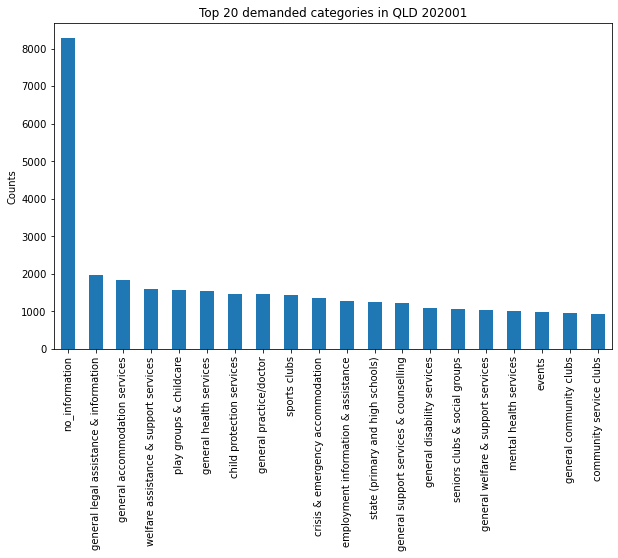

In [48]:
value_counts = df["CategoryName"].value_counts()
value_counts.head(20).plot(kind = "bar", ylabel = "Counts", figsize = (10, 6), title = "Top 20 demanded categories in QLD 202001")

In [ ]:
# in terms of finding out what user was intend to do, we can try to figure out the user's intention with not only WhatText but also 
# category name and path can help us, now we fulfill the missing value of WhatText with category name and path. 
# Here I assume the WhatText can represents the intention and demand of users.
# word cloud can give us initial analyses
# do as much as possible, make notes about the limitation
# In reflection, what have you learned?
# mention about the sensitivity and privacy issue in this analysis
# in presentation, "I wanna draw your attention on this..." can help to focus